# Build a Multi-User Conversational Financial Analyst Tool-Use AI Agent with In-Memory Persistence with LangGraph

This project will focus on building a Tool-Use Agentic AI System which acts as a Financial Analyst & Advisor. This agent will be conversational and can handle multiple user-sessions with their own separate conversational history.

The first project here will build a conversational tool-use agentic system with in-memory persistence.

![](https://i.imgur.com/dKD7L6Q.png)

### Financial Analyst Tool-Use Agentic AI System with In-Memory Persistence

This project focuses on building a **Tool-Use Agentic AI System** that acts as a Financial Analyst & Advisor. The agent will be conversational and can handle multiple user sessions with their own separate conversational history. By leveraging the `create_react_agent` function from **LangGraph**, this project adds in-memory persistence for enhanced user interaction continuity. The workflow comprises the following components:

1. **Agent System Prompt**:
   - The agent validates input queries for relevance and specificity.
   - It provides detailed market analysis or stock-specific insights depending on the user's query.
   - For invalid queries, the agent responds professionally and guides the user appropriately.
   - The system delivers concise, professional responses emphasizing data clarity and accuracy.

   **Flows**:
   - **Flow 1**: For general market trends, the agent analyzes data and suggests stock opportunities using tools like `SEARCH_WEB` and `GET_GENERAL_MARKET_DATA`.
   - **Flow 2**: For stock-specific queries, the agent validates the stock ticker, retrieves relevant data, and provides insights using tools such as `GET_STOCK_FUNDAMENTAL_INDICATOR_METRICS` and `GET_STOCK_PRICE_METRICS`.

2. **Financial Analysis Tools**:
   The system integrates multiple tools to ensure comprehensive and precise insights:
   - **SEARCH_WEB**: Fetches general stock market information from the web.
   - **GET_STOCK_FUNDAMENTAL_INDICATOR_METRICS**: Provides insights into key financial metrics such as P/E ratio, ROE, etc.
   - **GET_STOCK_NEWS**: Extracts the latest news and updates related to stocks or markets.
   - **GET_GENERAL_MARKET_DATA**: Fetches data on overall market trends and performance.
   - **GET_STOCK_TICKER**: Validates and fetches stock ticker symbols based on user queries.
   - **GET_STOCK_PRICE_METRICS**: Retrieves price trends, performance, and metrics for specific stocks.

3. **Stock Market Data Providers**:
   The system ensures real-time, reliable data by integrating with top providers like Yahoo Finance, Finviz, TMX, Cboe, and more, through platforms such as **OpenBB**.

4. **Memory Module**:
   - A memory module is introduced to store and manage user-specific conversational histories.
   - This enables the agent to maintain session continuity and provide context-aware responses for recurring users or prolonged interactions. __Here we store this in-memory.__

5. **Message Trimmer**:
   - Trims responses to ensure they are concise, professional, and reader-friendly, improving user experience and response quality.

6. **ReAct Reasoning Framework**:
   - The system employs **ReAct reasoning**, combining logical deduction with dynamic tool usage. This framework ensures precise and actionable results by dynamically selecting the right tools based on the query.

7. **Final Response**:
   - After processing the data from tool calls, the agentic system generates the final response.






## Install OpenAI, LangGraph and LangChain dependencies

In [0]:
!pip install -q langchain==0.3.14
!pip install -q langchain-openai==0.3.0
!pip install -q langchain-community==0.3.14
!pip install -q langgraph==0.2.64
!pip install -q langgraph-checkpoint-sqlite==2.0.5
# fix yfinance to stable version
!pip install -q yfinance==0.2.51

## Install OpenBB

In [0]:
!pip install -q openbb[all]==4.3.5

## Enter Open AI API Key

In [0]:
# from getpass import getpass

# OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter OpenBB Key

Get a free API key from [here](https://my.openbb.co/app/platform/pat)

In [0]:
# from getpass import getpass

# OPENBB_PAT = getpass('Enter OpenBB Personal Access Token (PAT): ')

Enter OpenBB Personal Access Token (PAT): ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [0]:
# TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


In [0]:
import os
# import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
OPENAI_KEY = os.environ['OPENAI_API_KEY']
OPENBB_PAT = os.environ['OPENBB_PAT']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']

## Setup Environment Variables

In [0]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [0]:
from openbb import obb
# takes 1 min to setup
obb.account.login(pat=OPENBB_PAT)

Extensions to add: alpha_vantage@1.3.5, biztoc@1.3.5, cboe@1.3.5, ecb@1.3.5, econometrics@1.4.5, finra@1.3.5, finviz@1.2.5, government_us@1.3.5, multpl@1.0.5, nasdaq@1.3.5, openbb_charting@2.2.5, quantitative@1.3.5, seeking_alpha@1.3.5, stockgrid@1.3.5, technical@1.3.5, tmx@1.2.5, tradier@1.2.5, wsj@1.3.5

Building...


## Create Financial Tools

**Financial Analysis Tools**:
   The system integrates multiple tools to get useful financial data and metrics:
   - **SEARCH_WEB**: Fetches general stock market information from the web.
   - **GET_STOCK_FUNDAMENTAL_INDICATOR_METRICS**: Provides insights into key financial metrics such as P/E ratio, ROE, etc.
   - **GET_STOCK_NEWS**: Extracts the latest news and updates related to stocks or markets.
   - **GET_GENERAL_MARKET_DATA**: Fetches data on overall market trends and performance.
   - **GET_STOCK_TICKER**: Validates and fetches stock ticker symbols based on user queries.
   - **GET_STOCK_PRICE_METRICS**: Retrieves price trends, performance, and metrics for specific stocks.

In [0]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool
import json
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

tavily_search = TavilySearchAPIWrapper()

@tool
def search_web(query: str, num_results=8) -> list:
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=num_results,
                                        search_depth='advanced',
                                        include_answer=False,
                                        include_raw_content=True)
    return results

@tool
def get_stock_ticker_symbol(stock_name: str) -> str:
    """Get the symbol, name and CIK for any publicly traded company"""
    # Use OpenBB to search for stock ticker symbol and company details by name.
    # The provider "sec" fetches data from the U.S. Securities and Exchange Commission (SEC).
    res = obb.equity.search(stock_name, provider="sec")

    # Convert the result to a DataFrame and format it as markdown for readability.
    stock_ticker_details = res.to_df().to_markdown()

    # Prepare the output with the stock details.
    output = """Here are the details of the company and its stock ticker symbol:\n\n""" + stock_ticker_details
    return output

@tool
def get_stock_price_metrics(stock_ticker: str) -> str:
    """Get historical stock price data, stock price quote and price performance data
       like price changes for a specific stock ticker"""

    # Fetch the latest stock price quote using "cboe" provider.
    res = obb.equity.price.quote(stock_ticker, provider='cboe')
    price_quote = res.to_df().to_markdown()

    # Retrieve stock price performance metrics (e.g., percentage change) using "finviz" provider.
    res = obb.equity.price.performance(symbol=stock_ticker, provider='finviz')
    price_performance = res.to_df().to_markdown()

    # Fetch historical price data for the past year using "yfinance" provider.
    end_date = datetime.now()
    start_date = (end_date - timedelta(days=365)).strftime("%Y-%m-%d")
    res = obb.equity.price.historical(symbol=stock_ticker, start_date=start_date,
                                      interval='1d', provider='yfinance')
    price_historical = res.to_df().to_markdown()

    # Combine the results into a formatted output.
    output = ("""Here are the stock price metrics and data for the stock ticker symbol """ + stock_ticker + """: \n\n""" +
              "Price Quote Metrics:\n\n" + price_quote +
              "\n\nPrice Performance Metrics:\n\n" + price_performance +
              "\n\nPrice Historical Data:\n\n" + price_historical)
    return output

@tool
def get_stock_fundamental_indicator_metrics(stock_ticker: str) -> str:
    """Get fundamental indicator metrics for a specific stock ticker"""

    # Retrieve fundamental financial ratios (e.g., P/E ratio, ROE) using "fmp" provider.
    res = obb.equity.fundamental.ratios(symbol=stock_ticker, period='annual',
                                        limit=10, provider='fmp')
    fundamental_ratios = res.to_df().to_markdown()

    # Fetch additional fundamental metrics (e.g., EBITDA, revenue growth) using "yfinance" provider.
    res = obb.equity.fundamental.metrics(symbol=stock_ticker, period='annual',
                                        limit=10, provider='yfinance')
    fundamental_metrics = res.to_df().to_markdown()

    # Combine fundamental ratios and metrics into a single output.
    output = ("""Here are the fundamental indicator metrics and data for the stock ticker symbol """ + stock_ticker + """: \n\n""" +
              "Fundamental Ratios:\n\n" + fundamental_ratios +
              "\n\nFundamental Metrics:\n\n" + fundamental_metrics)
    return output

@tool
def get_stock_news(stock_ticker: str) -> str:
    """Get news article headlines for a specific stock ticker"""

    # Define the date range to fetch news (last 45 days).
    end_date = datetime.now()
    start_date = (end_date - timedelta(days=45)).strftime("%Y-%m-%d")

    # Retrieve news headlines for the stock using "tmx" provider.
    res = obb.news.company(symbol=stock_ticker, start_date=start_date, provider='tmx', limit=50)
    news = res.to_df()

    # Extract relevant columns (symbols and titles) and format as markdown.
    news = news[['symbols', 'title']].to_markdown()

    # Prepare the output with the news headlines.
    output = ("""Here are the recent news headlines for the stock ticker symbol """ + stock_ticker + """: \n\n""" + news)
    return output

@tool
def get_general_market_data() -> str:
    """Get general data and indicators for the whole stock market including,
       most actively traded stocks based on volume, top price gainers and top price losers.
       Useful when you want an overview of the market and what stocks to look at."""

    # Retrieve the most actively traded stocks using "yfinance" provider.
    res = obb.equity.discovery.active(sort='desc', provider='yfinance', limit=15)
    most_active_stocks = res.to_df().to_markdown()

    # Fetch the top price gainers using "yfinance" provider.
    res = obb.equity.discovery.gainers(sort='desc', provider='yfinance', limit=15)
    price_gainers = res.to_df().to_markdown()

    # Retrieve the top price losers using "yfinance" provider.
    res = obb.equity.discovery.losers(sort='desc', provider='yfinance', limit=15)
    price_losers = res.to_df().to_markdown()

    # Combine the market data into a single formatted output.
    output = ("""Here's some detailed information of the stock market which includes most actively traded stocks, gainers and losers:\n\n""" +
              "Most actively traded stocks:\n\n" + most_active_stocks +
              "\n\nTop price gainers:\n\n" + price_gainers +
              "\n\nTop price losers:\n\n" + price_losers)
    return output


## Build the Conversational Tool-use Agentic AI System with Transient In-Memory Store

Here we use an in-memory store for persisting conversational messages between the user and the agent temporarily (transient). This is in-memory so it would be deleted once you shut down the agent or your system.

In [0]:
AGENT_SYS_PROMPT = """Role: You are an AI stock market assistant tasked with providing investors
with up-to-date, detailed information on individual stocks or advice based on general market data.

Objective: Assist data-driven stock market investors by giving accurate,
complete, but concise information relevant to their questions about individual
stocks or general advice on useful stocks based on general market data and trends.

Capabilities: You are given a number of tools as functions. Use as many tools
as needed to ensure all information provided is timely, accurate, concise,
relevant, and responsive to the user's query.

Starting Flow:
Input validation: Determine if the input is asking about a specific company
or stock ticker (Flow 2). If not, check if they are asking for general advice on potentially useful stocks
based on current market data (Flow 1). Otherwise, respond in a friendly, positive, professional tone
that you don't have information to answer as you can only provide financial advice based on market data.
For each of the flows related to valid questions use the following instructions:

Flow 1:
A. Market Analysis: If the query is valid and the user wants to get general advice on the market
or stocks worth looking into for investing, leverage the general market data tool to get relevant data.
In case you need more information then you can also use web search.

Flow 2:
A. Symbol extraction: If the query is valid and is related to a specific company or companies,
extract the company name or ticker symbol from the question.
If a company name is given, look up the ticker symbol using a tool.
If the ticker symbol is not found based on the company, try to
correct the spelling and try again, like changing "microsfot" to "microsoft",
or broadening the search, like changng "southwest airlines" to a shorter variation
like "southwest" and increasing "limit" to 10 or more. If the company or ticker is
still unclear based on the question or conversation so far, and the results of the
symbol lookup, then ask the user to clarify which company or ticker.

B. Information retrieval: Determine what data the user is seeking on the symbol
identified. Use the appropriate tools to fetch the requested information. Only use
data obtained from the tools. You may use multiple tools in a sequence. For instance,
first determine the company's symbol, then retrieve price data using the symbol
and fundamental indicator data etc. For specific queries only retrieve data using the most relevant tool.
If detailed analysis is needed, you can call multiple tools to retrieve data first.
In case you still need more information then you can also use web search.

Response Generation Flow:
Compose Response: Analyze the retrieved data carefully and provide a comprehensive answer to the user in a clear and concise format,
in a friendly professional tone, emphasizing the data retrieved.
If the user asks for recommendations you can give some recommendations
but emphasize the user to do their own research before investing.
When generating the final response in markdown,
if there are special characters in the text, such as the dollar symbol,
ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5

Example Interaction:
User asks: "What is the PE ratio for Eli Lilly?"
Chatbot recognizes 'Eli Lilly' as a company name.
Chatbot uses symbol lookup to find the ticker for Eli Lilly, returning LLY.
Chatbot retrieves the PE ratio using the proper function with symbol LLY.
Chatbot responds: "The PE ratio for Eli Lilly (symbol: LLY) as of May 12, 2024 is 30."

Check carefully and only call the tools which are specifically named below.
Only use data obtained from these tools.
"""

In [0]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4o")
tokens = enc.encode(AGENT_SYS_PROMPT)
print(f"Number of tokens: {len(tokens)}")

Number of tokens: 755


In [0]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langchain_core.messages import trim_messages
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tools = [get_stock_ticker_symbol,
         get_stock_price_metrics,
         get_stock_fundamental_indicator_metrics,
         get_stock_news,
         search_web,
         get_general_market_data]

llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)



SYS_MSG = SystemMessage(content=AGENT_SYS_PROMPT)
def chatbot(state: State):
    messages = trim_messages(
            state["messages"],
            max_tokens=127000,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            include_system=True, # not necessary here as we send the sys prompt separately
            allow_partial=True,
    )
    return {"messages": [llm_with_tools.invoke([SYS_MSG] + messages)]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    ['tools', END]
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
financial_analyst_agent = graph_builder.compile(checkpointer=memory)

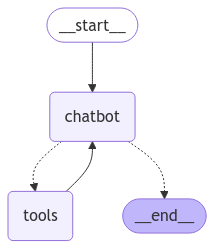

In [0]:
from IPython.display import display, Image, Markdown

Image(financial_analyst_agent.get_graph().draw_mermaid_png())

In [0]:
def call_conversational_agent(agent, prompt, user_session_id, verbose=False):
    events = agent.stream(
        {"messages": [{"role": "user", "content": prompt}]},
        {"configurable": {"thread_id": user_session_id}},
        stream_mode="values",
    )

    print('Running Agent. Please wait...')
    for event in events:
        if verbose:
            event["messages"][-1].pretty_print()

    display(Markdown(event["messages"][-1].content))

## Test the Agentic System with In-Memory Persistence

### Simulating User 1

In [0]:
uid = 'john001'
query = 'what are 2 most important metrics for fundamental analysis to pick stocks?'
call_conversational_agent(agent=financial_analyst_agent,
                          prompt=query,
                          user_session_id=uid,
                          verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

what are 2 most important metrics for fundamental analysis to pick stocks?
================================== Ai Message ==================================

Two of the most important metrics for fundamental analysis when picking stocks are:

1. **Price-to-Earnings (P/E) Ratio**: This metric measures a company's current share price relative to its per-share earnings. It is used to determine whether a stock is overvalued or undervalued compared to its earnings. A lower P/E ratio might indicate that the stock is undervalued, while a higher P/E ratio could suggest overvaluation.

2. **Return on Equity (ROE)**: This metric measures a company's profitability by revealing how much profit a company generates with the money shareholders have invested. It is calculated by dividing net income by shareholder's equity. A higher ROE indicates a more efficient company in terms of generating

Two of the most important metrics for fundamental analysis when picking stocks are:

1. **Price-to-Earnings (P/E) Ratio**: This metric measures a company's current share price relative to its per-share earnings. It is used to determine whether a stock is overvalued or undervalued compared to its earnings. A lower P/E ratio might indicate that the stock is undervalued, while a higher P/E ratio could suggest overvaluation.

2. **Return on Equity (ROE)**: This metric measures a company's profitability by revealing how much profit a company generates with the money shareholders have invested. It is calculated by dividing net income by shareholder's equity. A higher ROE indicates a more efficient company in terms of generating profit from equity.

These metrics provide insights into a company's valuation and profitability, helping investors make informed decisions. However, it's important to consider them in conjunction with other financial indicators and qualitative factors.

In [0]:
query = 'get these two for Amazon?'
call_conversational_agent(agent=financial_analyst_agent,
                          prompt=query,
                          user_session_id=uid,
                          verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

get these two for Amazon?
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_SZuAt65V0uNgbMbV7zkwK7I3)
 Call ID: call_SZuAt65V0uNgbMbV7zkwK7I3
  Args:
    stock_name: Amazon
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name           |     cik |
|---:|:---------|:---------------|--------:|
|  0 | AMZN     | AMAZON COM INC | 1018724 |
================================== Ai Message ==================================
Tool Calls:
  get_stock_fundamental_indicator_metrics (call_0Cv2hi0addshDgzSZqnxCYf2)
 Call ID: call_0Cv2hi0addshDgzSZqnxCYf2
  Args:
    stock_ticker: AMZN
================================= Tool Message =================================
Name: ge

For Amazon (symbol: AMZN), here are the two important metrics for fundamental analysis:

1. **Price-to-Earnings (P/E) Ratio**: The P/E ratio for Amazon is 50.41. This indicates how much investors are willing to pay per dollar of earnings, and a higher P/E ratio might suggest that the stock is overvalued compared to its earnings.

2. **Return on Equity (ROE)**: The ROE for Amazon is 22.56%. This measures the company's profitability by showing how much profit it generates with the money shareholders have invested. A higher ROE indicates more efficient use of equity.

These metrics provide insights into Amazon's valuation and profitability. However, it's always advisable to consider these in conjunction with other financial indicators and qualitative factors before making investment decisions.

In [0]:
query = 'do the same for google'
call_conversational_agent(agent=financial_analyst_agent,
                          prompt=query,
                          user_session_id=uid,
                          verbose=False)

Running Agent. Please wait...


For Alphabet Inc. (Google) with the stock ticker GOOGL, here are the two important metrics for fundamental analysis:

1. **Price-to-Earnings (P/E) Ratio**: The P/E ratio for Alphabet Inc. is 25.41. This indicates how much investors are willing to pay per dollar of earnings, and a lower P/E ratio might suggest that the stock is undervalued compared to its earnings.

2. **Return on Equity (ROE)**: The ROE for Alphabet Inc. is 32.10%. This measures the company's profitability by showing how much profit it generates with the money shareholders have invested. A higher ROE indicates more efficient use of equity.

These metrics provide insights into Alphabet Inc.'s valuation and profitability. As always, it's advisable to consider these in conjunction with other financial indicators and qualitative factors before making investment decisions.

In [0]:
query = 'which stock might be the better pick?'
call_conversational_agent(agent=financial_analyst_agent,
                          prompt=query,
                          user_session_id=uid,
                          verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

which stock might be the better pick?
================================== Ai Message ==================================

When comparing Amazon (AMZN) and Alphabet Inc. (GOOGL), here are some key considerations based on the fundamental metrics:

1. **Price-to-Earnings (P/E) Ratio**:
   - **Amazon (AMZN)**: 50.41
   - **Alphabet Inc. (GOOGL)**: 25.41
   - A lower P/E ratio might suggest that Alphabet is more reasonably valued compared to Amazon.

2. **Return on Equity (ROE)**:
   - **Amazon (AMZN)**: 22.56%
   - **Alphabet Inc. (GOOGL)**: 32.10%
   - Alphabet has a higher ROE, indicating it is more efficient in generating profit from shareholders' equity.

3. **Growth Prospects**:
   - Consider the growth prospects and market position of each company. Alphabet has shown strong earnings growth, which might be appealing to growth-oriented investors.

4. **Industry and Market Trend

When comparing Amazon (AMZN) and Alphabet Inc. (GOOGL), here are some key considerations based on the fundamental metrics:

1. **Price-to-Earnings (P/E) Ratio**:
   - **Amazon (AMZN)**: 50.41
   - **Alphabet Inc. (GOOGL)**: 25.41
   - A lower P/E ratio might suggest that Alphabet is more reasonably valued compared to Amazon.

2. **Return on Equity (ROE)**:
   - **Amazon (AMZN)**: 22.56%
   - **Alphabet Inc. (GOOGL)**: 32.10%
   - Alphabet has a higher ROE, indicating it is more efficient in generating profit from shareholders' equity.

3. **Growth Prospects**:
   - Consider the growth prospects and market position of each company. Alphabet has shown strong earnings growth, which might be appealing to growth-oriented investors.

4. **Industry and Market Trends**:
   - Both companies are leaders in their respective industries, but they operate in different sectors. Consider the industry trends and how each company is positioned to capitalize on them.

5. **Risk Factors**:
   - Evaluate the risk factors associated with each company, including market volatility, regulatory challenges, and competitive pressures.

Ultimately, the decision on which stock might be the better pick depends on your investment goals, risk tolerance, and market outlook. It's important to conduct thorough research and consider both quantitative and qualitative factors before making an investment decision.

In [0]:
uid = 'bond007'
query = 'how is nvidia doing currently?'
call_conversational_agent(agent=financial_analyst_agent,
                          prompt=query,
                          user_session_id=uid,
                          verbose=True)

Running Agent. Please wait...
================================ Human Message =================================

how is nvidia doing currently?
================================== Ai Message ==================================
Tool Calls:
  get_stock_ticker_symbol (call_GpPId6CDs5skGaPgXZE3MRrT)
 Call ID: call_GpPId6CDs5skGaPgXZE3MRrT
  Args:
    stock_name: Nvidia
================================= Tool Message =================================
Name: get_stock_ticker_symbol

Here are the details of the company and its stock ticker symbol:

|    | symbol   | name        |     cik |
|---:|:---------|:------------|--------:|
|  0 | NVDA     | NVIDIA CORP | 1045810 |
================================== Ai Message ==================================
Tool Calls:
  get_stock_price_metrics (call_lJJ2aBKhmbm1rgskOpdg3AvB)
 Call ID: call_lJJ2aBKhmbm1rgskOpdg3AvB
  Args:
    stock_ticker: NVDA
  get_stock_fundamental_indicator_metrics (call_hCKl05qxndx9GtXGyCta0g59)
 Call ID: call_hCKl05qxndx9GtXGyCta

Here's a comprehensive overview of NVIDIA Corporation (symbol: NVDA) as of the latest data:

### Stock Price Metrics
- **Current Price**: \$120.18
- **Price Change**: -\$24.20 (-20.44%)
- **52-Week High**: \$153.13
- **52-Week Low**: \$60.70
- **Volume**: 818,830,895 shares

### Fundamental Indicators
- **Market Cap**: \$2.9 trillion
- **PE Ratio**: 46.62
- **Forward PE**: 26.63
- **PEG Ratio (TTM)**: 1.022
- **Gross Margin**: 75.98%
- **Operating Margin**: 62.06%
- **Profit Margin**: 55.04%
- **Return on Equity**: 123.77%

### Recent News
- **NVIDIA Launches AI Foundation Models for RTX AI PCs** (Jan 6, 2025)
- **NVIDIA Expands Omniverse With Generative Physical AI** (Jan 6, 2025)
- **NVIDIA Announces Blueprint for AI Retail Shopping Assistants** (Jan 10, 2025)
- **NVIDIA Partners With Industry Leaders to Advance Genomics, Drug Discovery, and Healthcare** (Jan 13, 2025)

### Analysis
NVIDIA is currently experiencing a significant price drop, with a notable decrease in its stock price. Despite this, the company maintains strong fundamental metrics, including a high market cap and robust profit margins. Recent news highlights NVIDIA's continued innovation in AI and partnerships in various industries, which may influence future performance.

Please let me know if you need more specific details or further analysis!

In [0]:
query = 'what about intel?'
call_conversational_agent(agent=financial_analyst_agent,
                          prompt=query,
                          user_session_id=uid,
                          verbose=False)

Running Agent. Please wait...


Here's a detailed overview of Intel Corporation (symbol: INTC) as of the latest data:

### Stock Price Metrics
- **Current Price**: \$20.42
- **Price Change**: -\$0.54 (-2.66%)
- **52-Week High**: \$46.63
- **52-Week Low**: \$18.51
- **Volume**: 83,582,097 shares

### Fundamental Indicators
- **Market Cap**: \$87.51 billion
- **Forward PE Ratio**: 21.51
- **PEG Ratio (TTM)**: 0.618
- **Gross Margin**: 40.07%
- **Operating Margin**: -1.05%
- **Profit Margin**: -29.42%
- **Return on Equity**: -15.60%

### Recent News
- **Intel Extends Leadership in AI PCs and Edge Computing at CES 2025** (Jan 6, 2025)
- **Intel to Report Fourth-Quarter and Full-Year 2024 Financial Results** (Jan 8, 2025)
- **Intel Capital to Become Standalone Investment Fund** (Jan 14, 2025)
- **Intel and Biden-Harris Administration Finalize $7.86 Billion Funding Award Under US CHIPS Act** (Nov 26, 2024)

### Analysis
Intel is currently facing challenges with a significant drop in stock price and negative profit margins. However, the company is actively involved in strategic initiatives, including AI and edge computing, and has received substantial funding under the US CHIPS Act. These efforts may help improve its market position in the future.

If you need more specific details or further analysis, feel free to ask!

In [0]:
query = 'which is a better stock to pick?'
call_conversational_agent(agent=financial_analyst_agent,
                          prompt=query,
                          user_session_id=uid,
                          verbose=False)

Running Agent. Please wait...


When considering which stock to pick between NVIDIA (NVDA) and Intel (INTC), it's important to evaluate several factors, including financial performance, market position, growth potential, and risk. Here's a brief comparison based on the latest data:

### NVIDIA (NVDA)
- **Market Cap**: \$2.9 trillion
- **PE Ratio**: 46.62
- **Profit Margin**: 55.04%
- **Recent Performance**: Significant price drop, but strong fundamentals and continued innovation in AI.
- **Growth Potential**: High, with strong involvement in AI and technology sectors.

### Intel (INTC)
- **Market Cap**: \$87.51 billion
- **Forward PE Ratio**: 21.51
- **Profit Margin**: -29.42%
- **Recent Performance**: Price decline and negative profit margins, but strategic initiatives in AI and government support.
- **Growth Potential**: Moderate, with challenges in profitability but potential upside from strategic initiatives.

### Considerations
- **NVIDIA** is currently more profitable and has a strong market position, especially in AI and technology. However, its stock is more expensive in terms of PE ratio.
- **Intel** is facing profitability challenges but is involved in strategic initiatives that could lead to future growth. Its stock is cheaper in terms of valuation.

### Recommendation
- **NVIDIA** may be a better pick for those looking for a company with strong growth potential and profitability in the tech sector.
- **Intel** might appeal to investors looking for a turnaround story with potential upside from strategic initiatives.

Ultimately, the decision should align with your investment goals, risk tolerance, and market outlook. It's advisable to conduct further research and consider consulting with a financial advisor before making any investment decisions.

We have successfully built an AI Agent which can do detailed financial analysis for us and is completely conversational. Next up we will see how to use persistent memory on the disk

# Build a Multi-User Conversational Financial Analyst Tool-Use AI Agent with On-Disk Persistence with LangGraph

This project will focus on building a Tool-Use Agentic AI System which acts as a Financial Analyst & Advisor. This agent will be conversational and can handle multiple user-sessions with their own separate conversational history.

The first project here will build a conversational tool-use agentic system with on-disk persistence.

![](https://i.imgur.com/dKD7L6Q.png)

### Financial Analyst Tool-Use Agentic AI System with In-Memory Persistence

This project focuses on building a **Tool-Use Agentic AI System** that acts as a Financial Analyst & Advisor. The agent will be conversational and can handle multiple user sessions with their own separate conversational history. By leveraging the `create_react_agent` function from **LangGraph**, this project adds in-memory persistence for enhanced user interaction continuity. The workflow comprises the following components:

1. **Agent System Prompt**:
   - The agent validates input queries for relevance and specificity.
   - It provides detailed market analysis or stock-specific insights depending on the user's query.
   - For invalid queries, the agent responds professionally and guides the user appropriately.
   - The system delivers concise, professional responses emphasizing data clarity and accuracy.

   **Flows**:
   - **Flow 1**: For general market trends, the agent analyzes data and suggests stock opportunities using tools like `SEARCH_WEB` and `GET_GENERAL_MARKET_DATA`.
   - **Flow 2**: For stock-specific queries, the agent validates the stock ticker, retrieves relevant data, and provides insights using tools such as `GET_STOCK_FUNDAMENTAL_INDICATOR_METRICS` and `GET_STOCK_PRICE_METRICS`.

2. **Financial Analysis Tools**:
   The system integrates multiple tools to ensure comprehensive and precise insights:
   - **SEARCH_WEB**: Fetches general stock market information from the web.
   - **GET_STOCK_FUNDAMENTAL_INDICATOR_METRICS**: Provides insights into key financial metrics such as P/E ratio, ROE, etc.
   - **GET_STOCK_NEWS**: Extracts the latest news and updates related to stocks or markets.
   - **GET_GENERAL_MARKET_DATA**: Fetches data on overall market trends and performance.
   - **GET_STOCK_TICKER**: Validates and fetches stock ticker symbols based on user queries.
   - **GET_STOCK_PRICE_METRICS**: Retrieves price trends, performance, and metrics for specific stocks.

3. **Stock Market Data Providers**:
   The system ensures real-time, reliable data by integrating with top providers like Yahoo Finance, Finviz, TMX, Cboe, and more, through platforms such as **OpenBB**.

4. **Memory Module**:
   - A memory module is introduced to store and manage user-specific conversational histories.
   - This enables the agent to maintain session continuity and provide context-aware responses for recurring users or prolonged interactions. __Here we store this on-disk in a database.__

5. **Message Trimmer**:
   - Trims responses to ensure they are concise, professional, and reader-friendly, improving user experience and response quality.

6. **ReAct Reasoning Framework**:
   - The system employs **ReAct reasoning**, combining logical deduction with dynamic tool usage. This framework ensures precise and actionable results by dynamically selecting the right tools based on the query.

7. **Final Response**:
   - After processing the data from tool calls, the agentic system generates the final response.




### Build the Conversational Tool-use Agentic AI System with Persistent On-disk External Memory Store

Here we use a persistent SQLite database to permanently store our conversations between the agent and the user.

We will use `SqliteSaver` which helps to store separate conversation histories per user or session.

This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time. The memory is persisted on-disk so can be accessed anytime.



In [0]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove ALL conversation histories
# ok if you get rm: cannot remove 'memory.db': No such file or directory  because initially no memory exists
!rm memory.db*

In [0]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langchain_core.messages import trim_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tools = [get_stock_ticker_symbol,
         get_stock_price_metrics,
         get_stock_fundamental_indicator_metrics,
         get_stock_news,
         search_web,
         get_general_market_data]

llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)



SYS_MSG = SystemMessage(content=AGENT_SYS_PROMPT)
def chatbot(state: State):
    messages = trim_messages(
            state["messages"],
            max_tokens=127000,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=True,
    )
    return {"messages": [llm_with_tools.invoke([SYS_MSG] + messages)]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = MemorySaver()
financial_analyst_agent = graph_builder.compile()

In [0]:
from IPython.display import Image, display, Markdown

display(Image(financial_analyst_agent.get_graph().draw_mermaid_png()))

In [0]:
from langgraph.checkpoint.sqlite import SqliteSaver

def call_conversational_agent(agent_graph, prompt, user_session_id, verbose=False):
    with SqliteSaver.from_conn_string("memory.db") as memory:
        agent = agent_graph.compile(checkpointer=memory)
        events = agent.stream(
            {"messages": [{"role": "user", "content": prompt}]},
            {"configurable": {"thread_id": user_session_id}},
            stream_mode="values",
        )

        print('Running Agent, please wait...')
        for event in events:
            if verbose:
                event["messages"][-1].pretty_print()

    display(Markdown(event["messages"][-1].content))

## Test the Agentic System with On-Disk Persistence

Let's now simulate User 1 using the agent

In [0]:
uid = 'john001'
query = 'analyze overall stock price trends for NVIDIA'
call_conversational_agent(agent_graph=graph_builder,
                          prompt=query,
                          user_session_id=uid,
                          verbose=True)

In [0]:
query = 'do the same for Intel please'
call_conversational_agent(agent_graph=graph_builder,
                          prompt=query,
                          user_session_id=uid,
                          verbose=False)

In [0]:
query = 'which is the better pick?'
call_conversational_agent(agent_graph=graph_builder,
                          prompt=query,
                          user_session_id=uid,
                          verbose=False)

Let's now simulate User 2 using the agent

In [0]:
uid = 'bond007'
query = 'summarize key points from NVIDIA earnings call Q4 2024'
call_conversational_agent(agent_graph=graph_builder,
                          prompt=query,
                          user_session_id=uid,
                          verbose=True)

In [0]:
query = 'do the same for intel'
call_conversational_agent(agent_graph=graph_builder,
                          prompt=query,
                          user_session_id=uid,
                          verbose=False)

In [0]:
query = 'which has a better outlook?'
call_conversational_agent(agent_graph=graph_builder,
                          prompt=query,
                          user_session_id=uid,
                          verbose=False)